# The Autoencoder

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import music21

from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from music21 import *
np.random.seed(42)

We load each file from the 'dataset' directory into the stream object

In [2]:
# Define save directory
src_dir = './datasets/'

# Identify list of MIDI files
song_list = os.listdir(src_dir)

streams = []
# Load and make list of stream objects
for song in song_list:
    stream = converter.parse(src_dir+song)
    streams.append(stream)

In [3]:
len(streams)

389

### Preparing for encoding

In [4]:
# Define function to test whether stream is monophonic
def monophonic(stream):
    try:
        length = len(instrument.partitionByInstrument(stream).parts)
    except:
        length = 0
    return length == 1

In [5]:
# Merge notes into chords
original_scores = [stream.chordify() for stream in streams if monophonic(stream)]

Note that if we apply _.chordify()_ - depicted in the figure below - without removing polyphonic music, we will accidentally merge notes played by different instruments into a chord.

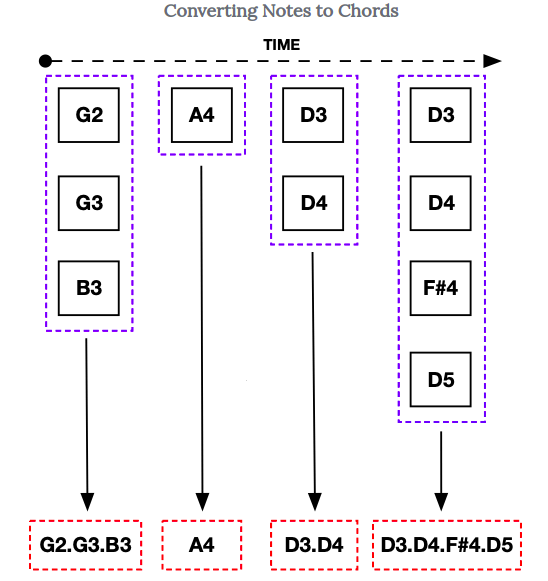

We now need to extract notes, chords, and durations from each stream. We'll first define three empty lists: original_chords, original_durations, original_keys. We can enumerate over the list of streams. For each stream, we'll identify and store all notes, chords, and durations, as well as the piece's key.

In [6]:
# Define empty lists of lists
original_chords = [[] for _ in original_scores]
original_durations = [[] for _ in original_scores]
original_keys = []

# Extract notes, chords, durations, and keys
for i, song in enumerate(original_scores):
    original_keys.append(str(song.analyze('key')))
    for element in song:
        if isinstance(element, note.Note):
            original_chords[i].append(element.pitch)
            original_durations[i].append(element.duration.quarterLength)
        elif isinstance(element, chord.Chord):
            original_chords[i].append('.'.join(str(n) for n in element.pitches))
            original_durations[i].append(element.duration.quarterLength)

The next step is to identify the unique set of chords and durations. We will then construct dictionaries that map them to integers.

In [7]:
# Map unique chords to integers
unique_chords = np.unique([i for s in original_chords for i in s])
chord_to_int = dict(zip(unique_chords, list(range(0, len(unique_chords)))))

# Map unique durations to integers
unique_durations = np.unique([i for s in original_durations for i in s])
duration_to_int = dict(zip(unique_durations, list(range(0, len(unique_durations)))))

In [8]:
len(unique_chords)

1462

In [9]:
len(unique_durations)

17

After we've trained our model and made predictions, we will want to map our integer predictions back to notes, chords, and durations. We'll invert the _chord_to_int_ and _duration_to_int_ dictionaries below.

In [10]:
# Invert chord and duration dictionaries
int_to_chord = {i: c for c, i in chord_to_int.items()}
int_to_duration = {i: c for c, i in duration_to_int.items()}

Finally, we can define our training sequences, which consist of 32 consecutive notes and chords, along with their corresponding durations. We will first do this for autoencoder-type models, where our set of features and targets are the same.

In [11]:
# Define sequence length
sequence_length = 32

# Define empty arrays for train data
train_chords = []
train_durations = []

# Construct training sequences for chords and durations
for s in range(len(original_chords)):
    chord_list = [chord_to_int[chord] for chord in original_chords[s]]
    duration_list = [duration_to_int[duration] for duration in original_durations[s]]
    for i in range(len(chord_list) - sequence_length):
        train_chords.append(chord_list[i:i+sequence_length])
        train_durations.append(duration_list[i:i+sequence_length])

In [12]:
len(train_chords)

10795

In [13]:
train_chords = np.array(train_chords)

In [15]:
train_chords

array([[ 517,  987, 1446, ..., 1455,  539, 1012],
       [ 987, 1446,  323, ...,  539, 1012, 1455],
       [1446,  323, 1198, ..., 1012, 1455,  539],
       ...,
       [ 517,  493,  361, ..., 1369, 1323, 1352],
       [ 493,  361, 1455, ..., 1323, 1352, 1387],
       [ 361, 1455,  769, ..., 1352, 1387, 1342]])

In [16]:
# Define number of samples, chords and notes, and input dimension
number_of_samples = train_chords.shape[0]
number_of_chords = train_chords.shape[1]
input_dim = number_of_chords * sequence_length

# Set number of latent features
latent_dim = 2

In [18]:
train_chords = np.array(train_chords, dtype = 'float32')

In [20]:
train_chords = tf.keras.utils.to_categorical(train_chords)

In [21]:
train_chords = train_chords.transpose(0, 2, 1)

In [22]:
train_chords.shape

(10795, 1462, 32)

In [23]:
sequence_length = train_chords.shape[1]

In [24]:
input_dim = number_of_chords*sequence_length

In [25]:
train_chords_flat = train_chords.reshape(number_of_samples, input_dim)

In [26]:
train_chords_flat.shape

(10795, 46784)

An autoencoder consists of two networks, which are stacked-vertically and joined by a latent vector. The inputs to an autoencoder are first passed to an __encoder__ model, which typically consists of one or more dense layers. The final layer in the encoder model is called a __latent vector__. This is a bottleneck that forces the features extracted in the encoder to be compressed into a small number of latent features.

The latent vector connects to a __decoder model__, which upsamples or decompresses the data. The number of nodes in each successive decoder layer increases. The final output layer has the same dimensions as the input layer of the encoder model.

In contrast to discriminative models, which attempt to identify a decision boundary, autoencoders are trained to reconstruct the input data - in this case, a song - as accurately as is possible, subject to the constraints placed by the size of the latent vector. For this reason, autoencoders simply use the inputs as the target.

We'll use an autoencoder to construct our first generative model of music. To keep things as simple as is possible, we'll adopt the architecture introduced in [Briot, Hadjerest, and Pachet (2019)](https://arxiv.org/pdf/1709.01620.pdf) as a simplification to the [DeepBach](https://arxiv.org/pdf/1612.01010.pdf) model. For another example of an autoencoder model of music generation, see the [DeepHear](https://fephsun.github.io/2015/09/01/neural-music.html) system.

The input data, as we've constructed it, consists of one-hot encoded vectors that represent notes and chords. We will ignore durations for now.


We now define the architecture for the model, starting with the input layer for the encoder network, encoder_input, and the input layer for the decoder network, latent. Note that the latent layer is also the output of the encoder network. We next define a dense layer, encoded, that connects the inputs to the latent vector and another dense layer, decoded, which connects the latent vector to the output vector.

In [27]:
# Define encoder input shape
encoder_input = tf.keras.layers.Input(shape = (input_dim))

# Define dense encoding layer connecting input to latent vector
encoded = tf.keras.layers.Dense(latent_dim, activation = 'tanh')(encoder_input)

# Define the encoder and decoder models
encoder = tf.keras.Model(encoder_input, encoded, name = 'encoder')

encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 46784)]           0         
_________________________________________________________________
dense (Dense)                (None, 2)                 93570     
Total params: 93,570
Trainable params: 93,570
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Define decoder input shape
latent = tf.keras.layers.Input(shape = (latent_dim))

# Define dense decoding layer connecting latent vector to output
decoded = tf.keras.layers.Dense(input_dim, activation = 'sigmoid')(latent)

#Define the decoder models
decoder = tf.keras.Model(latent, decoded, name = 'decoder')

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 46784)             140352    
Total params: 140,352
Trainable params: 140,352
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Define autoencoder model
autoencoder = tf.keras.Model(encoder_input, decoder(encoded), name = 'autoencoder')

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 46784)]           0         
_________________________________________________________________
dense (Dense)                (None, 2)                 93570     
_________________________________________________________________
decoder (Functional)         (None, 46784)             140352    
Total params: 233,922
Trainable params: 233,922
Non-trainable params: 0
_________________________________________________________________


Finally, we define a decoder model - decoder, and our autoencoder - autoencoder. Note that _.Model()_ has an inputs and outputs argument. For the decoder model, we pass the latent vector as an input and the decoded network as an output. For the full autoencoder, we use encoder_input as the input and pass the decoder model, evaluated using the output of the encoder network, encoded, as an input.

The only steps that remain are to compile the model and then train using the .fit() method. There are two important details to notice:
<ul>
    <li> Our input values will consist of 0s and 1s, and our predicted values will be real numbers between 0 and 1. We can use a binary_crossentropy loss function. </li>
    <li> Both the input values and targeted values are the same: train_chords_flat. </li>
</ul>

In [30]:
batch_size = 32
epochs = 150

In [31]:
# Compile autoencoder model
autoencoder.compile(loss = 'binary_crossentropy', optimizer='adam')

# Train autoencoder
history = autoencoder.fit(train_chords_flat, train_chords_flat, batch_size = batch_size, epochs = epochs)

Epoch 1/150
338/338 [==============================] - 45s 40ms/step - loss: 0.4968
Epoch 2/150
338/338 [==============================] - 10s 30ms/step - loss: 0.2330
Epoch 3/150
338/338 [==============================] - 10s 31ms/step - loss: 0.1331
Epoch 4/150
338/338 [==============================] - 10s 29ms/step - loss: 0.0858
Epoch 5/150
338/338 [==============================] - 10s 29ms/step - loss: 0.0598
Epoch 6/150
338/338 [==============================] - 10s 28ms/step - loss: 0.0441
Epoch 7/150
338/338 [==============================] - 10s 28ms/step - loss: 0.0339
Epoch 8/150
338/338 [==============================] - 10s 29ms/step - loss: 0.0269
Epoch 9/150
338/338 [==============================] - 10s 29ms/step - loss: 0.0219
Epoch 10/150
338/338 [==============================] - 10s 29ms/step - loss: 0.0182
Epoch 11/150
338/338 [==============================] - 10s 29ms/step - loss: 0.0155
Epoch 12/150
338/338 [==============================] - 10s 29ms/step - lo

We save the models.

In [32]:
encoder.save('./models/encoder.h5')

In [33]:
decoder.save('./models/decoder.h5')

In [34]:
autoencoder.save('./models/autoencoder.h5')

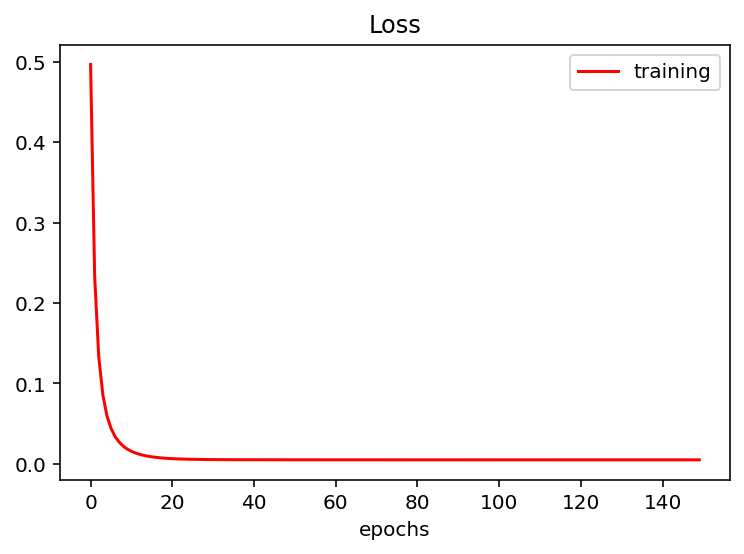

In [35]:
plt.title('Loss')
loss = history.history['loss']
plt.plot(range(epochs), loss, color='red', label='training')
plt.xlabel('epochs')
plt.legend(loc='best')
    
plt.show()

In [36]:
#from tensorflow.keras.models import load_model
#load_model('./models/autoencoder.h5')

The last step is to generate music. Since we set the sequence length to 32, the autoencoder will take 32 chords and notes as inputs and produce a fixed-length "song" that consists of a sequence of 32 chords and notes. The autoencoder is trained to generate outputs that are highly similar to the input; however, our objective is to generate new music. To do this, we'll pass a randomly-generated latent vector to the decoder model, which we defined as a subnetwork of the autoencoder model.

In [37]:
# Generate chords from randomly generated latent vector
generated_chords = decoder(np.random.normal(size=(1,latent_dim))).numpy().reshape(number_of_chords, sequence_length).argmax(0)

Notice that we reshaped the output of the autoencoder into an array with the same dimensions as our original input. We then took the _argmax()_ over the first dimension of the array. This returns an integer value that corresponds to a chord, which we'll identify in the code block below.

In [38]:
# Identify chord sequence from integer sequence
chord_sequence = [int_to_chord[c] for c in generated_chords]

Finally, we can create a stream object using music21, set the instrument as guitar, append the sequence of chords our model generated, and then export everything as a MIDI file.

In [39]:
# Set location to save generated music
generated_dir = './generated/'

# Generate stream with guitar as instrument
generated_stream = music21.stream.Stream()
generated_stream.append(instrument.Guitar())

# Append notes and chords to stream object
for j in range(len(chord_sequence)):
    try:
        generated_stream.append(note.Note(chord_sequence[j].replace('.', ' ')))
    except:
        generated_stream.append(chord.Chord(chord_sequence[j].replace('.', ' ')))

generated_stream.write('midi', fp = generated_dir + 'ae.mid')

'./generated/ae.mid'

In [40]:
# Play midi file
def play_midi(filename):
    mf = midi.MidiFile()
    mf.open(filename)
    mf.read()
    mf.close()
    stream = midi.translate.midiFileToStream(mf)
    stream.show('midi')

In [41]:
play_midi('./generated/ae.mid')